In [1]:
from data_utils import load_binary_MNIST
from models import MnistNet
import torch
from tqdm import tqdm
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

colors = ['black','#377eb8', '#ff7f00', '#4daf4a',
              '#984ea3', '#a65628', '#f781bf',
              '#999999', '#e41a1c', '#dede00']
markers = [ 'h', '*', '<', 'o', 's', 'v', 'D' ]

In [2]:
lr = 0.1
epochs = 250 # instead of the original 50

In [3]:
def mean_accuracy(logits, y):
    preds = (logits > 0.).float()
    return ((preds - y).abs() < 1e-2).float().mean().item()

In [4]:
def fit(model, optim, criterion, train_set, epochs=50):
    model.train()

    for i in tqdm(range(epochs)):
        optim.zero_grad()
        logits = model(train_set['images'])
        loss = criterion(logits, train_set['labels'])
        loss.backward()
        optim.step()

def eval(model, dataset):
    model.eval()
    logits = model(dataset['images'])
    acc = mean_accuracy(logits, dataset['labels'])
    return acc

In [5]:
sps = [0.5, 0.625, 0.75, 0.825, 0.95, 1.0]
train_accs = []
test_accs = []

criterion = torch.nn.BCEWithLogitsLoss()

for sp in sps:
    train_accs += [[]]
    test_accs += [[]]
    train_set, test_set = load_binary_MNIST(spurious_correlation=sp)
    for k in range(5):
        model = MnistNet()
        optim = torch.optim.SGD(params=model.parameters(), lr=lr)
        fit(model, optim, criterion, train_set, epochs=epochs)
        train_accs[-1] += [eval(model, train_set)]
        test_accs[-1] += [eval(model, test_set)]

100%|██████████| 250/250 [11:14<00:00,  2.70s/it]


In [6]:
y_train = [np.mean(y) for y in train_accs]
y_train_std = [np.std(y) for y in train_accs]
y_test = [np.mean(y) for y in test_accs]
y_test_std = [np.std(y) for y in test_accs]

<Figure size 360x360 with 0 Axes>

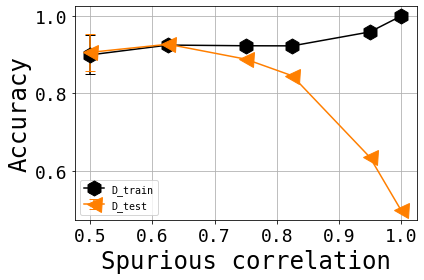

In [12]:
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Spurious correlation',fontsize=24)
ax.set_ylabel(r'Accuracy',fontsize=24)
ax.errorbar(x=sps, y=y_train, yerr=y_train_std, marker=markers[0], color=colors[0], 
            capsize=5,markersize=15, label='D_train')
ax.errorbar(x=sps, y=y_test, yerr=y_test_std, marker=markers[2], color=colors[2], 
            capsize=5,markersize=15, label='D_test')
ax.grid()
plt.tight_layout()
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
plt.legend()
plt.savefig(f'plots/mnist_ood_failure.pdf')


In [16]:
np.save('results/mnist_ood_failure_train.npy', np.array(train_accs))
np.save('results/mnist_ood_failure_test.npy', np.array(test_accs))